In [2]:
from peft import AutoPeftModelForCausalLM, PeftModelForCausalLM
from huggingface_hub import list_repo_refs
from transformers import AutoTokenizer, AutoModelForCausalLM

In [4]:
tokenizer = AutoTokenizer.from_pretrained("mnoukhov/pythia410m-tldr-sft")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
tokenizer.add_special_tokens({"pad_token": "<|padding|>"}) 

0

In [16]:
tokenizer.pad_token_id

1

In [12]:
example_text = "hello my name is mr hello"

In [24]:
toks = tokenizer(example_text + tokenizer.eos_token, padding="max_length", max_length=7, truncation=True)

In [25]:
toks

{'input_ids': [25521, 619, 1416, 310, 278, 83, 23120], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [26]:
sum(toks['attention_mask'])

7

In [2]:
base_model_name = "vwxyzjn/EleutherAI_pythia-1b-deduped__sft__tldr"
base_model_revision = "sft__55513__1706646024"

In [35]:
model_path = "/home/toolkit/trl_results/mnoukhov/EleutherAI_pythia-1b-deduped__sft__tldr_dpo_costa_1b_fp16.yml_3d94f50_b9ff2_merged/main"

In [36]:
base_model = AutoModelForCausalLM.from_pretrained(model_path)

In [37]:
base_model.push_to_hub("mnoukhov/EleutherAI_pythia-1b-deduped__sft__tldr_dpo_costa_1b_fp16.yml_3d94f50_b9ff2_merged")

model.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mnoukhov/EleutherAI_pythia-1b-deduped__sft__tldr_dpo_costa_1b_fp16.yml_3d94f50_b9ff2_merged/commit/cd8f4bf53ab02881549cb73b6271005b2e8c3be6', commit_message='Upload GPTNeoXForCausalLM', commit_description='', oid='cd8f4bf53ab02881549cb73b6271005b2e8c3be6', pr_url=None, pr_revision=None, pr_num=None)

In [4]:
adapter_repo = "mnoukhov/EleutherAI_pythia-1b-deduped__sft__tldr_dpo_1b_fp16.yml_24e9f83"

In [5]:
refs = list_repo_refs(adapter_repo)

In [6]:
for branch in refs.branches:
    if branch.name == "main":
        continue

    model = PeftModelForCausalLM.from_pretrained(base_model, adapter_repo, revision=branch.name)
    merged = model.merge_and_unload()
    merged.push_to_hub(f"{adapter_repo}_merged", revision=branch.name)
    print(branch.name)

adapter_config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

step2324


adapter_model.safetensors:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

step1743


adapter_model.safetensors:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

step1162


adapter_model.safetensors:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

step581


adapter_model.safetensors:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

step1


In [1]:
from datasets import load_dataset, builder, load_from_disk
builder.has_sufficient_disk_space = lambda needed_bytes, directory=".": True  

In [4]:
ds = load_from_disk("/home/toolkit/trl_results/vwxyzjn_summarize_from_feedback_tldr_3_filtered_oai_preprocessing_1706381144/vwxyzjn_EleutherAI_pythia-1b-deduped__dpo__tldr")

In [11]:
ds['generations_dpo__55513__1707379566'][0][-1]

'?'

In [13]:
ppo_ds = load_from_disk("vwxyzjn_summarize_from_feedback_tldr_3_filtered_oai_preprocessing_1706381144/vwxyzjn_EleutherAI_pythia-1b-deduped__ppo_left_padding_new_nowhiten_reward__tldr")

In [24]:
text = ppo_ds["generations_ppo_left_padding_new_nowhiten_reward__55513__1709671967"][0]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-6.9b-deduped")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
tokenizer.encode('<|padding|>')

[1]

In [5]:
ds = load_dataset("sophiex/hh-rlhf")

Generating train split:   0%|          | 0/160800 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8552 [00:00<?, ? examples/s]

In [9]:
tokds = ds.map(lambda x: tokenizer(x['prompt'] + x['chosen']), num_proc=16)

Map (num_proc=16):   0%|          | 0/160800 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/8552 [00:00<?, ? examples/s]

In [12]:
tokds = tokds.map(lambda x: {"length": len(x['input_ids'])})

Map:   0%|          | 0/160800 [00:00<?, ? examples/s]

Map:   0%|          | 0/8552 [00:00<?, ? examples/s]

In [16]:
import seaborn as sns

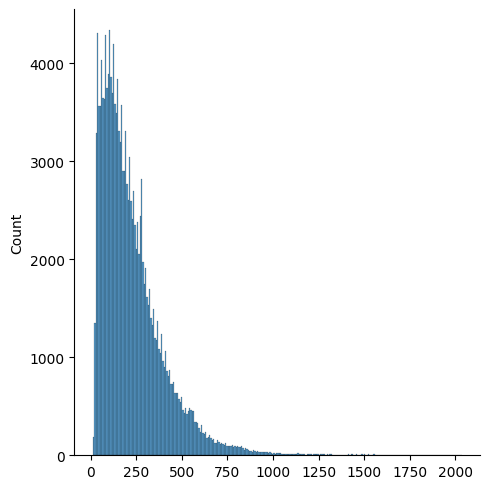

In [17]:
sns.displot(tokds["train"]["length"])

In [18]:
tokds = ds.map(lambda x: tokenizer(x['prompt']), num_proc=16)

Map (num_proc=16):   0%|          | 0/160800 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/8552 [00:00<?, ? examples/s]

In [19]:
tokds = tokds.map(lambda x: {"prompt_length": len(x['input_ids'])})

Map:   0%|          | 0/160800 [00:00<?, ? examples/s]

Map:   0%|          | 0/8552 [00:00<?, ? examples/s]

In [22]:
filttokds = tokds.filter(lambda x: x["prompt_length"] > 1024, num_proc=16)

Filter (num_proc=16):   0%|          | 0/160800 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/8552 [00:00<?, ? examples/s]

In [25]:
len(filttokds["test"])

31

In [ ]:
tokds = ds.map(lambda x: tokenizer(x['prompt']), num_proc=16)

In [31]:
ds = load_dataset("mnoukhov/summarize_from_feedback_tldr_3_filtered_oai_preprocessing_1706381144")

In [32]:
ds["train"] = ds["train"].filter(lambda x: x["has_comparison"] == True)

Filter:   0%|          | 0/116722 [00:00<?, ? examples/s]

In [34]:
ds.push_to_hub("mnoukhov/summarize_from_feedback_tldr_3_filtered_oai_preprocessing_1706381144_labelled")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

/home/toolkit/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 0.00 MB. The target location /home/toolkit/huggingface/hub only has 0.00 MB free disk space.
  warnings.warn(
/home/toolkit/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 0.00 MB. The target location /home/toolkit/huggingface/hub/datasets--mnoukhov--summarize_from_feedback_tldr_3_filtered_oai_preprocessing_1706381144_labelled/blobs only has 0.00 MB free disk space.
  warnings.warn(


README.md:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/mnoukhov/summarize_from_feedback_tldr_3_filtered_oai_preprocessing_1706381144_labelled/commit/a873a0b902f97283fb440254b724da8257439c33', commit_message='Upload dataset', commit_description='', oid='a873a0b902f97283fb440254b724da8257439c33', pr_url=None, pr_revision=None, pr_num=None)

In [33]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'subreddit', 'title', 'post', 'summary', 'query_token', 'query', 'reference_response', 'reference_response_token', 'reference_response_token_len', 'query_reference_response', 'query_reference_response_token', 'query_reference_response_token_response_label', 'query_reference_response_token_len', 'has_comparison'],
        num_rows: 9504
    })
    validation: Dataset({
        features: ['id', 'subreddit', 'title', 'post', 'summary', 'query_token', 'query', 'reference_response', 'reference_response_token', 'reference_response_token_len', 'query_reference_response', 'query_reference_response_token', 'query_reference_response_token_response_label', 'query_reference_response_token_len', 'has_comparison'],
        num_rows: 6447
    })
    test: Dataset({
        features: ['id', 'subreddit', 'title', 'post', 'summary', 'query_token', 'query', 'reference_response', 'reference_response_token', 'reference_response_token_len', 'query_